# The purpose of this notebook is to get data from multiple data sources and transform them to common structure.

In [136]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

In [105]:
# VARIABLES
pd.options.mode.chained_assignment = None
DF_MERGED_DELETE_OUTLIERS = True

In [106]:
def text_analysis(df, colname='title'):
    """
    counts: capital letters, small letters, special characters, blank signs, numbers, letters (small + capital)
    """
    nan_titles = df.isnull().values.any() 
    print(f"\nNaN titles dropped: { nan_titles }")
    df = df.dropna(subset=[colname])
    
    df["char_capital"] = df.get(colname).apply(lambda title: sum(1 for char in title if char.isupper()))
    df["char_small"] = df.get(colname).apply(lambda title: sum(1 for char in title if char.islower()))
    df["char_special"] = df.get(colname).apply(lambda title: sum(1 for char in title if not char.isalnum() and not char.isspace()))
    df["blank"] = df.get(colname).apply(lambda title: sum(1 for char in title if char.isspace()))
    df["numerical"] = df.get(colname).apply(lambda title: sum(1 for char in title if char.isdigit())) 
    df["letters"] = df.get(colname).apply(lambda title: sum(1 for char in title if char.isalpha()))
    
    print(f"\nEmpty titles dropped: {sum(df["letters"] == 0)}")
    df = df.loc[df["letters"]!=0]
    return df

In [107]:
def plot_letters(df, log_scale=False):
    """
    plots boxplot and histogram with number of letters
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    df.boxplot(column=["letters"], ax=axs[0])
    axs[0].set_title('Boxplot of alphabetical characters in titles')
    if log_scale:
        axs[0].set_yscale('log')

    sns.histplot(df["letters"], bins=10, kde=False, ax=axs[1], edgecolor="black")
    axs[1].set_xlabel('Counts')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of alphabetical characters in titles')
    if log_scale:
        axs[1].set_yscale('log')

    plt.tight_layout()
    plt.show()

In [108]:
def outliers_iqr(df):
    """
    detect outliers by IQR criteria
    returns outliers Pandas.df and updated original df
    """
    Q1 = df["letters"].quantile(0.25)
    Q3 = df["letters"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df["outlier"] = np.where((df["letters"] < lower_bound) | (df["letters"] > upper_bound), 1, 0)
    outliers = df[df["outlier"]==1].copy()
    outliers["tail"] = outliers["letters"].apply(lambda count: "L" if count < lower_bound else "U")
    outliers = outliers.groupby(["tail", "clickbait"])["clickbait"].count().reset_index(name='count')
    return outliers, df

In [109]:
def plot_outliers(outliers):
    """
    plots 2 barplots with outliers above and beneath bounds
    """
    lower_outliers = outliers[outliers['tail'] == 'L']
    upper_outliers = outliers[outliers['tail'] == 'U']

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    sns.barplot(x='clickbait', y='count', data=lower_outliers, ax=axs[0], hue="clickbait", palette={0: 'green', 1: 'red'})
    axs[0].set_title('Less alphabetical than lower bound IQR')
    axs[0].set_xlabel('Clickbait')
    axs[0].set_ylabel('Count')
    axs[0].set_xticks(ticks=[0, 1], labels=['Non-Clickbait (0)', 'Clickbait (1)'])

    sns.barplot(x='clickbait', y='count', data=upper_outliers, ax=axs[1], hue="clickbait", palette={0: 'green', 1: 'red'})
    axs[1].set_title('More alphabetical than upper bound IQR')
    axs[1].set_xlabel('Clickbait')
    axs[1].set_ylabel('Count')
    axs[1].set_xticks(ticks=[0, 1], labels=['Non-Clickbait (0)', 'Clickbait (1)'])

    plt.tight_layout()
    plt.show()

In [110]:
def clickbait_dist_plot(df):
        """
        piechart with clickbait distribution
        """
        print(f"\nShape: {df.shape}")
        num_clickbaits = df[df["clickbait"] == 1].shape[0]
        num_no_clickbaits = df[df["clickbait"] == 0].shape[0]

        print(f"Number of clickbaits: {num_clickbaits}")
        print(f"Number of no-clickbaits: {num_no_clickbaits}")

        labels = ['Clickbait', 'No-clickbait']
        sizes = [num_clickbaits, num_no_clickbaits]
        colors = ['red', 'green']
        explode = (0, 0)

        plt.figure(figsize=(8, 6))
        plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=False, startangle=90)
        plt.axis('equal')
        plt.title('Distribution of Clickbaits and No Clickbaits')
        plt.show()

In [111]:
def plot_clickbait_vs_noclickbait(df):
    """
    plots boxplots with comparison in features between clickbait and no-clickbait articles
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    data_1 = df[df["char_capital"] >= df["char_small"]]
    data_2 = df[df["numerical"] != 0]
    data_3 = df[df["char_special"] != 0]
    titles = [
        'Titles with more capital than small letters',
        'Titles with numerical data',
        'Titles with special characters'
    ]
    datasets = [data_1, data_2, data_3]

    for i in range(len(datasets)):
        dataset = datasets[i].groupby(["clickbait"])["clickbait"].count().reset_index(name='count')
        axs[i].bar(dataset['clickbait'], dataset['count'], color=['green', 'red'])

        axs[i].set_xlabel('Clickbait (0 = No, 1 = Yes)')
        axs[i].set_ylabel('Count')
        axs[i].set_title(titles[i])
        axs[i].set_xticks(dataset['clickbait'])

        axs[i].grid(axis='y')

    plt.tight_layout()
    plt.show()

In [112]:
def remove_outliers(df):
    return df.loc[df["outlier"]==0]

In [113]:
def print_stats(df):
    stats = df.drop(columns=["title"]).groupby('clickbait').agg(['mean', 'std'])
    print("\nStats:\n", stats)

In [114]:
def analyze_df(df, delete_outliers=False):
    """
    pipeline with above methods
    """
    columns = df.columns.tolist()
    print(f"Columns: {columns}")
    clickbait_dist_plot(df)
    df = text_analysis(df)
    print_stats(df)
    print("With outliers:")
    plot_letters(df)
    outliers, df = outliers_iqr(df)
    plot_outliers(outliers)
    if delete_outliers:    
        df = remove_outliers(df)
        print("Without outliers:")
        plot_letters(df)
    plot_clickbait_vs_noclickbait(df)
    # return df[columns]
    return df

 ## #1 Data source: kaggle
 https://www.kaggle.com/datasets/amananandrai/clickbait-dataset

In [115]:
df_1 = pd.read_csv("../data/clickbait_data.csv").drop_duplicates()
df_1.rename(columns={'headline': 'title'}, inplace=True)

Columns: ['title', 'clickbait']

Shape: (32000, 2)
Number of clickbaits: 15999
Number of no-clickbaits: 16001


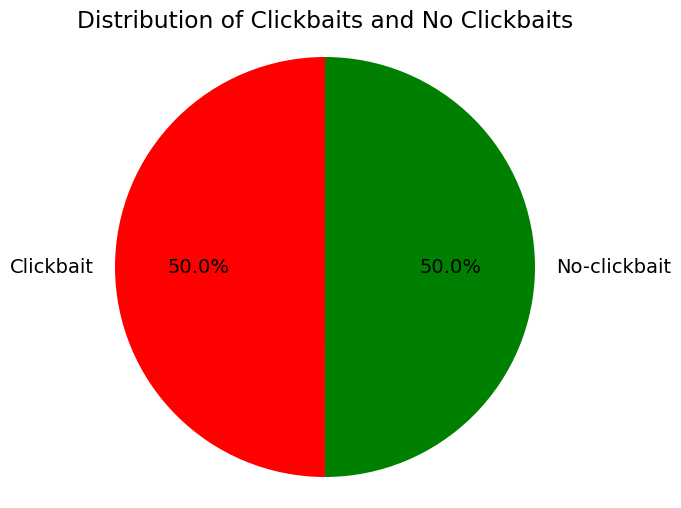


NaN titles dropped: False

Empty titles dropped: 0

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             4.631273  2.469242  38.795013  12.265831     0.721455  1.015306   
1             9.688356  2.866690  35.308957  10.295818     0.754047  1.074927   

              blank           numerical              letters             
               mean       std      mean       std       mean        std  
clickbait                                                                
0          7.194988  2.227746  0.510593  1.248460  43.426286  12.262935  
1          8.942684  2.660435  1.047003  1.427426  44.997312  12.532420  
With outliers:


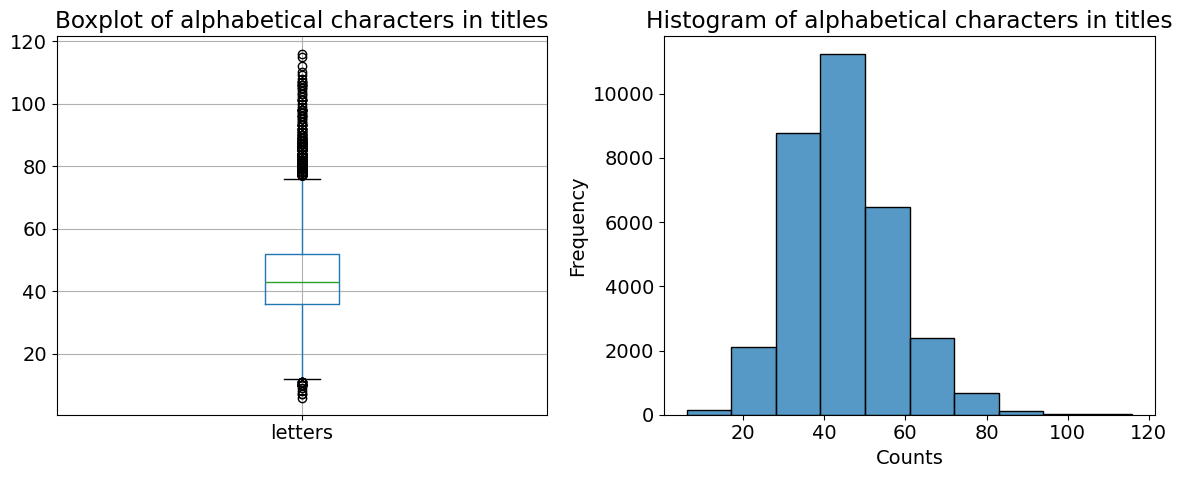

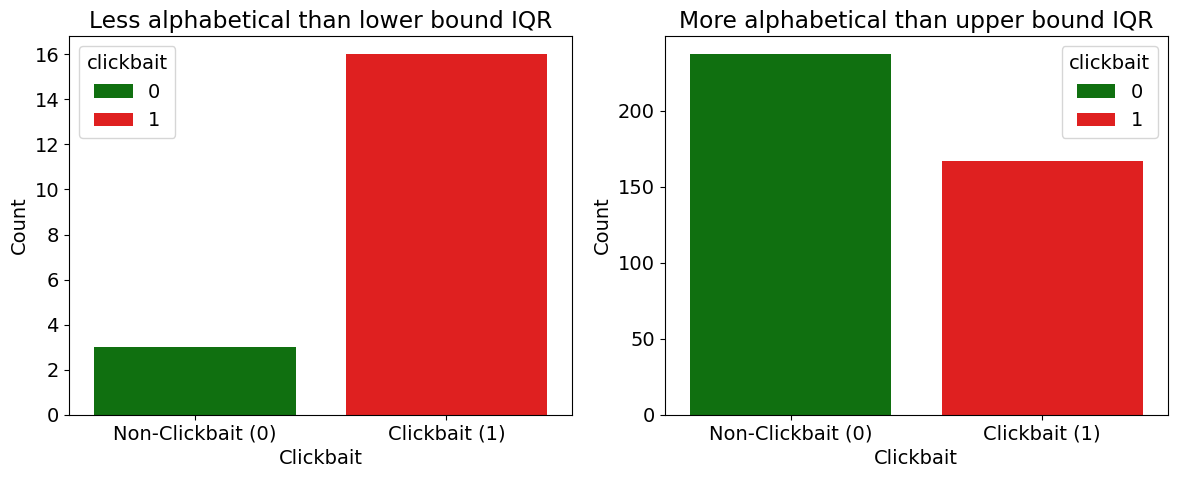

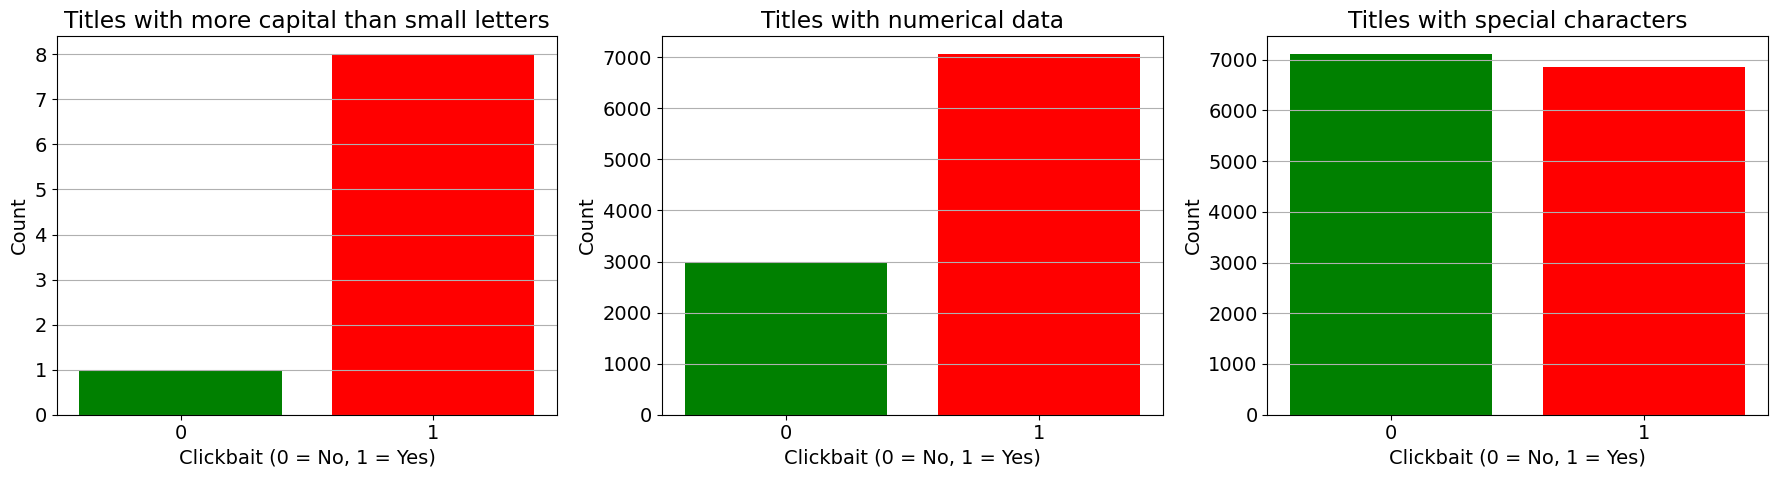

,title,clickbait,char_capital,char_small,char_special,blank,numerical,letters,outlier
0,Should I Get Bings,1,4,11,0,3,0,15,0
1,Which TV Female Friend Group Do You Belong In,1,10,27,0,8,0,37,0
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,14,43,3,13,0,57,0
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,12,42,2,11,0,54,0
4,A Couple Did A Stunning Photo Shoot With Their...,1,18,65,0,17,0,83,1
...,...,...,...,...,...,...,...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0,8,33,1,9,0,41,0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0,5,40,2,8,2,45,0
31997,Drone smartphone app to help heart attack vict...,0,1,63,0,11,0,64,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0,7,41,2,8,0,48,0


In [116]:
df_1.head()
analyze_df(df_1)

 ## #2 Data source: kaggle 
https://www.kaggle.com/datasets/vikassingh1996/news-clickbait-dataset?select=train2.csv

In [117]:
df_news_2 = pd.read_csv("../data/train2.csv").drop_duplicates()
df_news_2['label'] = df_news_2['label'].apply(lambda x: 1 if x == 'clickbait' else 0)

df_news_2.rename(columns={'label': 'clickbait'}, inplace=True)
df_2 = df_news_2[['title', 'clickbait']]

Columns: ['title', 'clickbait']

Shape: (20914, 2)
Number of clickbaits: 4266
Number of no-clickbaits: 16648


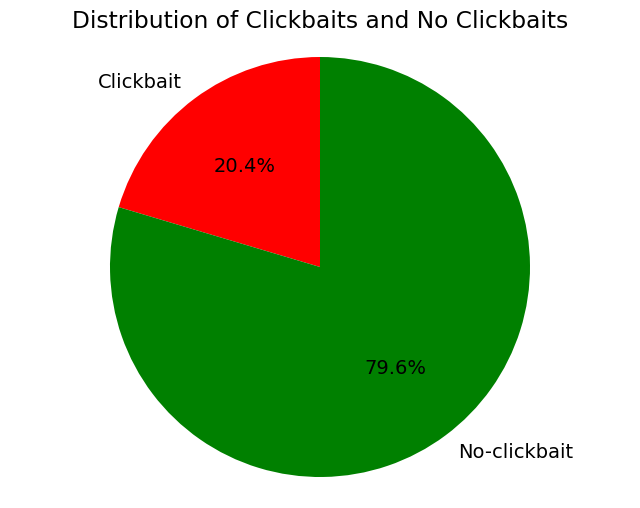


NaN titles dropped: False

Empty titles dropped: 0

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             7.016759  7.617762  54.441434  77.798081     1.822081  2.491760   
1             7.557900  8.099386  52.431317  88.317583     1.751055  2.745288   

               blank            numerical              letters             
                mean        std      mean       std       mean        std  
clickbait                                                                  
0          11.308626  15.975101  0.563371  1.520986  61.458193  83.902051  
1          11.522504  18.491532  0.802625  1.670221  59.989217  94.619246  
With outliers:


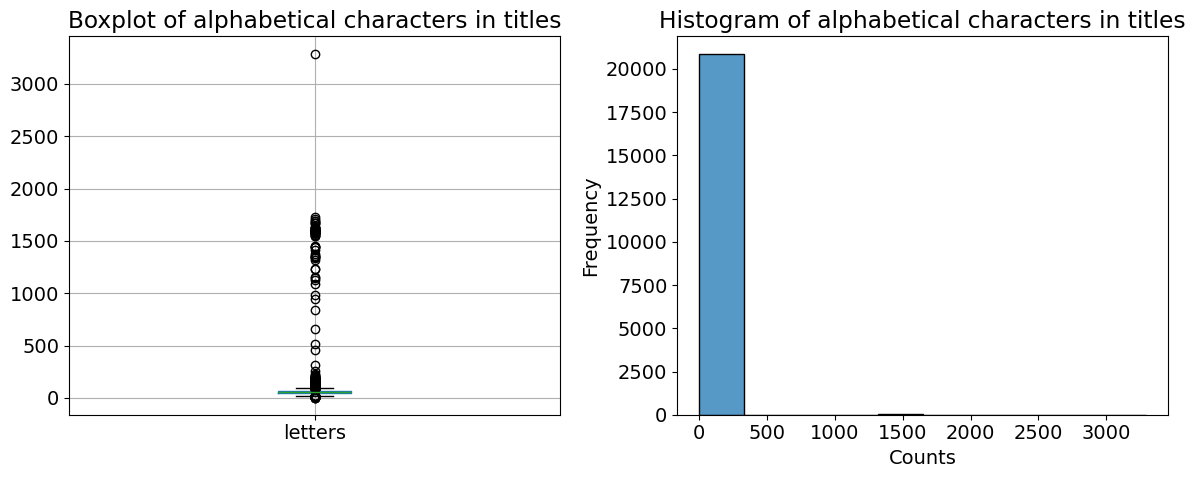

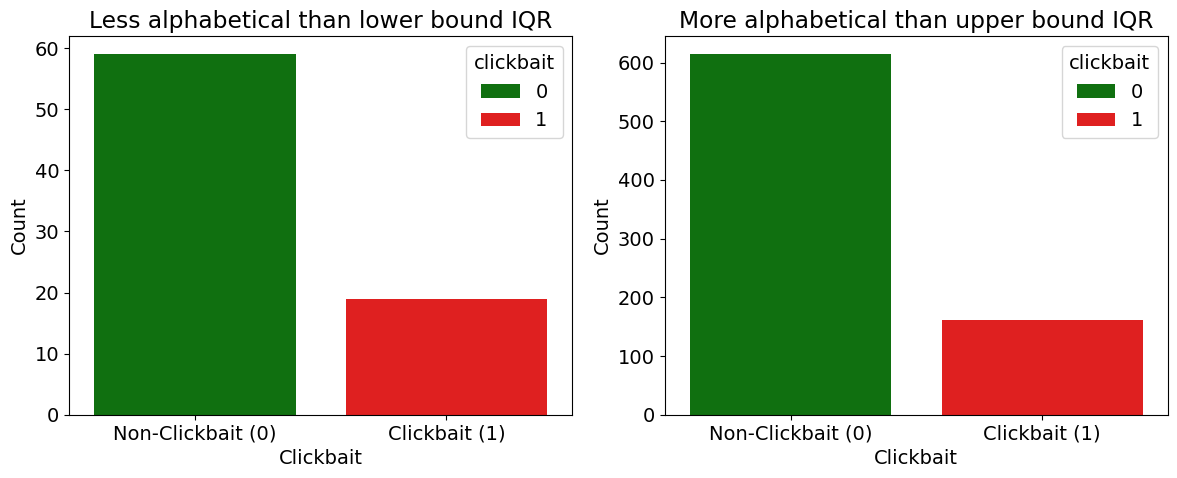

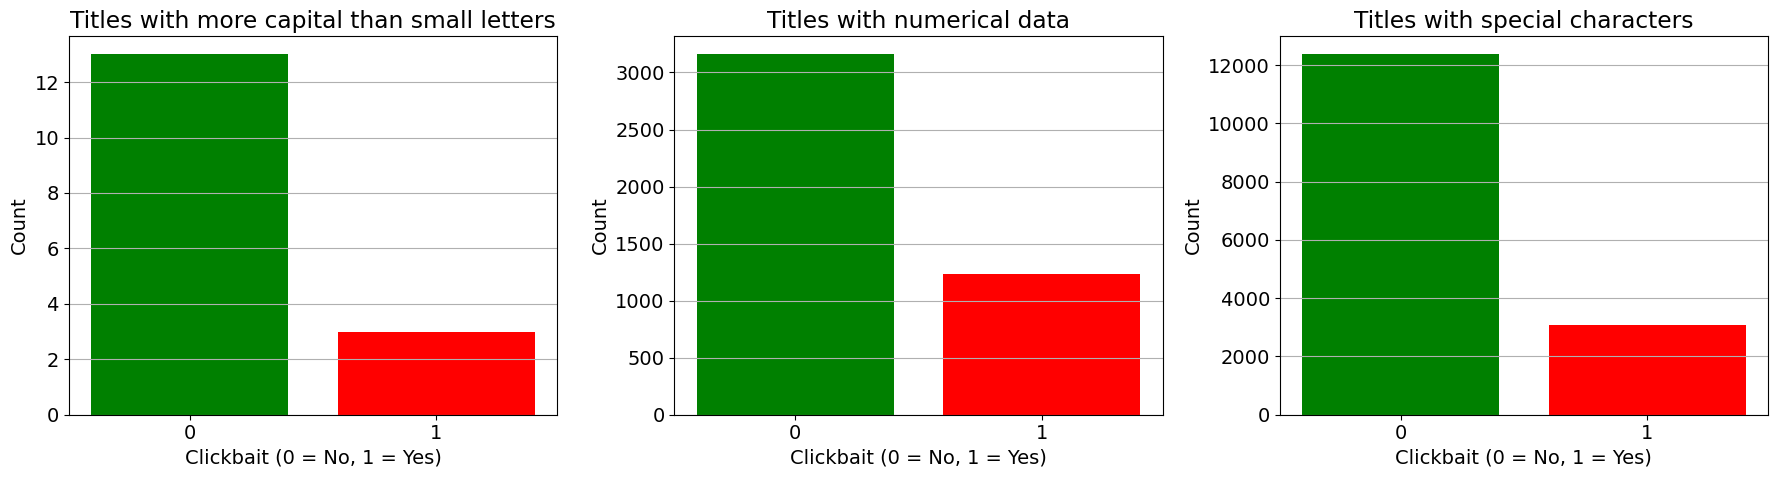

In [118]:
df_2.head()
df_2 = analyze_df(df_2)

 ## #3 Data source: clickbait challenge 
https://webis.de/events/clickbait-challenge/shared-task.html

In [119]:
def load_data_cc(name, columns=[]):
    """
    loads data from clickbait challenge webis corpus
    
    name (str): name of the folder
    columns (list): list of columns names to extract apart from 'id' and 'targetTitle'
    """
    data_file_path = f'../data/{name}/instances.jsonl'
    with open(data_file_path, 'rb') as file:
        data_df = pd.read_json(file,lines=True)

    target_file_path = f'../data/{name}/truth.jsonl'
    with open(target_file_path, 'rb') as file:
        labels = pd.read_json(file,lines=True)
    
    data_df = data_df[["id", "targetTitle"] + columns]
    labels = labels[["id", "truthClass"]]

    df = pd.merge(data_df, labels, on='id', how='left')
    df.drop(['id'], axis=1, inplace=True)
    df['truthClass'] = df['truthClass'].apply(lambda x: 1 if x == 'clickbait' else 0)
    df.rename(columns={'targetTitle': 'title', 'truthClass': 'clickbait'}, inplace=True)
    return df

In [120]:
files = [
    "clickbait17-train-170331", 
    "clickbait17-test-170720", 
    "clickbait17-validation-170630"
]
body_dfs = []
for filename in files:
    part_df = load_data_cc(filename)
    part_df = part_df[['title', 'clickbait']]
    body_dfs.append(part_df)
df_3 = pd.concat(body_dfs).reset_index(drop=True)
df_3 = df_3.drop_duplicates()

print(df_3.shape)

(38830, 2)


Columns: ['title', 'clickbait']

Shape: (38830, 2)
Number of clickbaits: 9530
Number of no-clickbaits: 29300


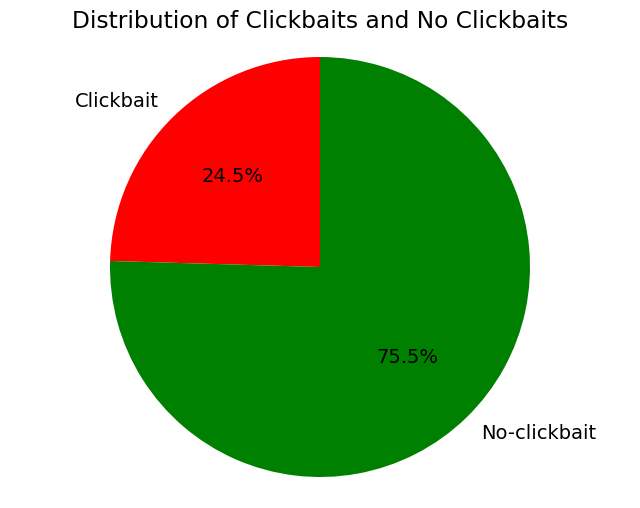


NaN titles dropped: False

Empty titles dropped: 0

Stats:
           char_capital           char_small            char_special            \
                  mean       std       mean        std         mean       std   
clickbait                                                                       
0             7.042082  7.195388  54.745427  69.125018     1.758020  2.729074   
1             7.500105  8.239454  50.947429  73.271862     1.765582  2.750367   

               blank            numerical              letters             
                mean        std      mean       std       mean        std  
clickbait                                                                  
0          11.378498  14.259585  0.590410  1.492527  61.787509  74.467116  
1          11.241658  15.637764  0.804512  1.803112  58.449213  79.268846  
With outliers:


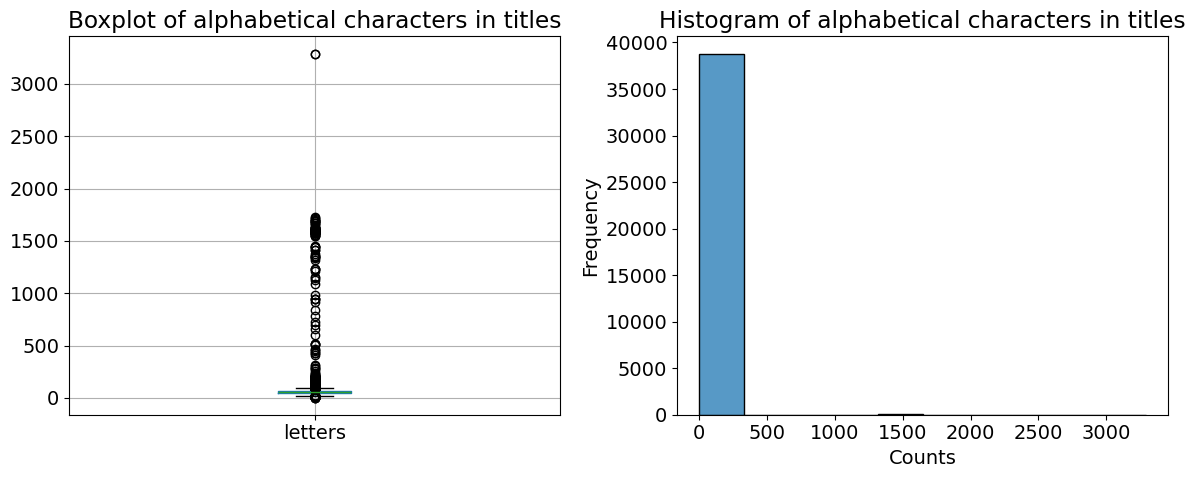

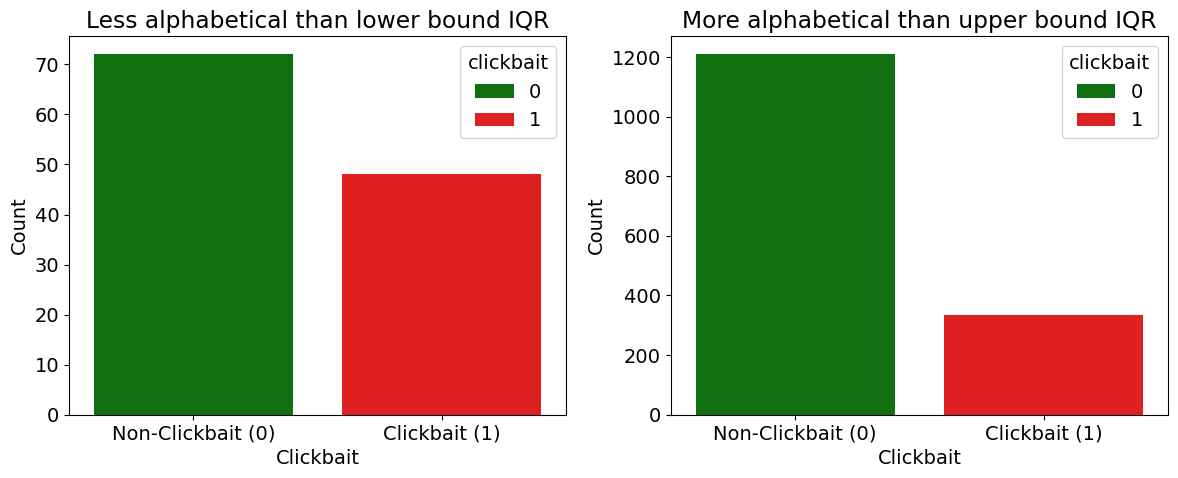

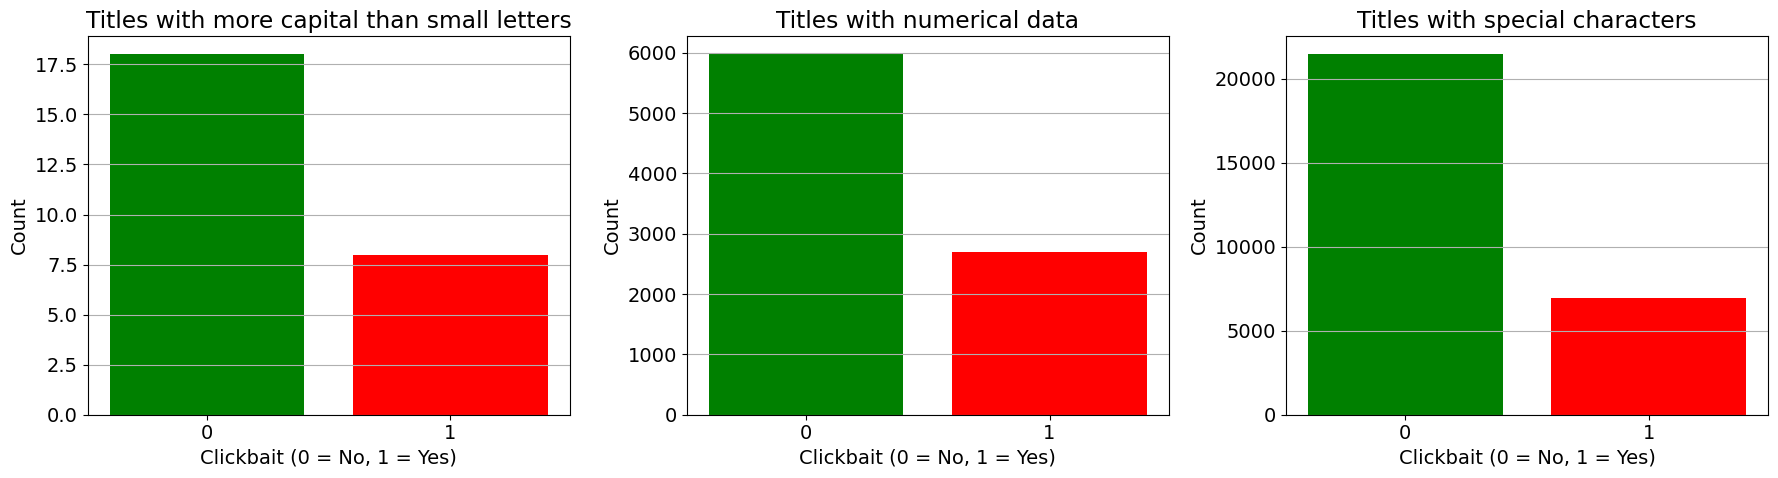

,title,clickbait,char_capital,char_small,char_special,blank,numerical,letters,outlier
0,Apple gives back gigabytes: iOS 9 'app thinnin...,0,3,79,4,16,1,82,0
1,Emerging Markets Suffer Largest Outflow in Sev...,0,7,40,0,7,0,47,0
2,U.S. Soccer should start answering tough quest...,1,5,50,2,9,0,55,0
3,How theme parks like Disney World left the mid...,0,3,49,0,10,0,52,0
4,Warning labels on your light bulbs,1,1,28,0,5,0,29,0
...,...,...,...,...,...,...,...,...,...
40971,"NBC News Video See Brazil Soccer Team, Pilot’s...",0,15,53,2,12,0,68,0
40972,Politico Scoop: Eric Trump Killed Two Deer,1,7,28,1,6,0,35,0
40973,Frenchs Forest high school may relocate to mak...,0,2,83,1,16,0,85,0
40974,Los Angeles Rams Jeff Fisher May Think Danny W...,0,12,57,0,13,0,69,0


In [121]:
df_3.head()
analyze_df(df_3)

## Datasets Clickbait distribution

In [122]:
def calc_dist_by_set(df_temp):
    df_counts = df_temp.groupby(["set", "clickbait"]).count().reset_index()
    df_counts.rename(columns={'title': 'counts'}, inplace=True)

    merged = df_counts.groupby("set")["counts"].sum().reset_index()
    merged.rename(columns={'counts': 'total_titles'}, inplace=True)

    df_counts = df_counts.merge(merged, on='set')
    df_counts["perc"] = round((df_counts["counts"] / df_counts["total_titles"]) * 100, 1)
    df_counts.drop(columns='total_titles', inplace=True)

    all = df_counts.groupby(["clickbait"]).sum()["counts"]
    per1 = round(all[0]/all.sum() * 100, 1)
    per2 = round(100 - per1, 1)
    p = df_counts["perc"].tolist()
    p.append(per1)
    p.append(per2)
    p = [str(str(label)+"%") for label in p]
    labels = [f"Kaggle 1 {[p[0], p[1]]}", f"Kaggle 2 {[p[2], p[3]]}", f"Challange {[p[4], p[5]]}", f"No-Clickbait {[p[6]]}", f"Clickbait {[p[7]]}"]
    for label in labels:
        print(label)
    return labels, df_counts

In [123]:
def plot_dist_by_set(labels, df_counts):
    values = df_counts["counts"].to_list()
    sources = [0, 0, 1, 1, 2, 2]  # Set 1, Set 1, Set 2, Set 2, Set 3, Set 3
    targets = [3, 4, 3, 4, 3, 4]  # Clickbait, No-Clickbait for each set

    values = df_counts["counts"].to_list() 
    # node_colors = px.colors.qualitative.Plotly
    node_colors = ["#63e0e0", "#8b95d9", "#dbca0b", "#6fed91", "#e64769"]  # Colors for Set 1, Set 2, Set 3, Clickbait, No-Clickbait
    link_colors = ["#6fed91", "#e64769", "#6fed91", "#e64769", "#6fed91", "#e64769"]

    fig = go.Figure(data=[go.Sankey(
        orientation="v",
        node=dict(
            pad=5,
            thickness=28,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors
        )
    )])


    fig.update_layout(
        title_text="",
        font_size=20
        )

    fig.show()

## Concatenate datasets

In [124]:
dfs = [
    df_1,
    df_2,
    df_3,
]

for df_ in dfs:
    print(df_.shape)

(32000, 2)
(20914, 9)
(38830, 2)


In [125]:
for i,df_ in enumerate(dfs):
    print("=========  " + str(i+1) +"- dataset =============")
    print(df_["clickbait"].value_counts())

=========  1- dataset =============
clickbait
0    16001
1    15999
Name: count, dtype: int64
=========  2- dataset =============
clickbait
0    16648
1     4266
Name: count, dtype: int64
=========  3- dataset =============
clickbait
0    29300
1     9530
Name: count, dtype: int64


In [126]:
df_1["set"] = 1
df_2["set"] = 2
df_3["set"] = 3
df_temp = pd.concat([df_1, df_2, df_3])

labels, df_counts = calc_dist_by_set(df_temp)
plot_dist_by_set(labels, df_counts)

Kaggle 1 ['50.0%', '50.0%']
Kaggle 2 ['79.6%', '20.4%']
Challange ['75.5%', '24.5%']
No-Clickbait ['67.5%']
Clickbait ['32.5%']


In [127]:
df_merged = pd.concat([df_1,df_2,df_3])
df_merged.shape

(91744, 10)

In [128]:
df_merged = df_merged.drop_duplicates()
df_merged.shape

(91744, 10)

Columns: ['title', 'clickbait', 'set', 'char_capital', 'char_small', 'char_special', 'blank', 'numerical', 'letters', 'outlier']

Shape: (91744, 10)
Number of clickbaits: 29795
Number of no-clickbaits: 61949


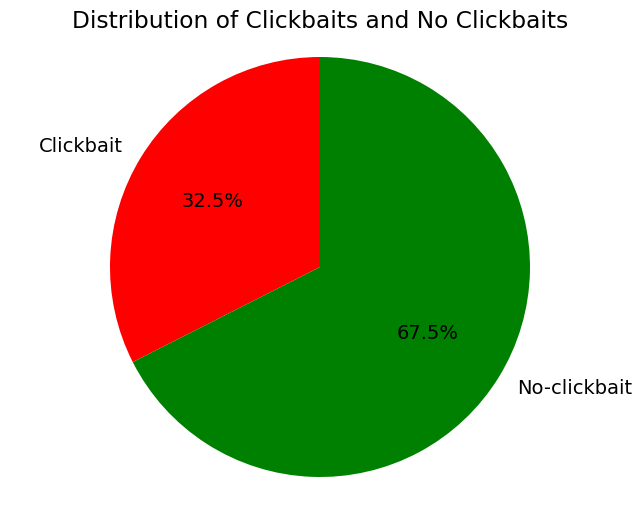


NaN titles dropped: True

Empty titles dropped: 0

Stats:
                 set           char_capital           char_small             \
               mean       std         mean       std       mean        std   
clickbait                                                                    
0          2.214677  0.827761     6.412581  6.539191  50.543851  63.034527   
1          1.782883  0.899838     8.683403  6.057029  42.762510  54.361953   

          char_special                blank            numerical            \
                  mean       std       mean        std      mean       std   
clickbait                                                                    
0             1.507498  2.381836  10.279149  13.013257  0.562527  1.441835   
1             1.220339  2.090653  10.047391  11.505769  0.934452  1.596223   

             letters              outlier            
                mean        std      mean       std  
clickbait                                         

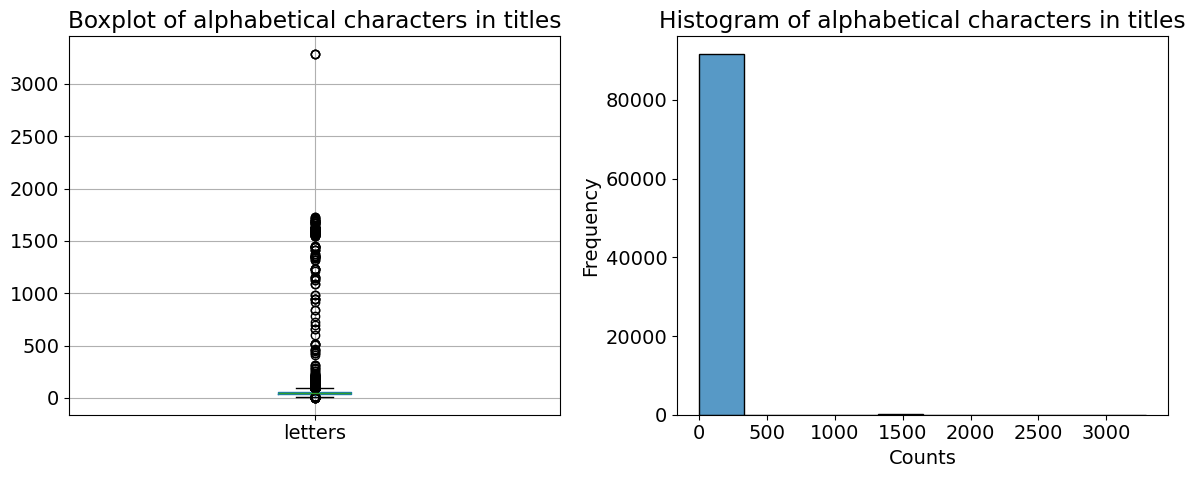

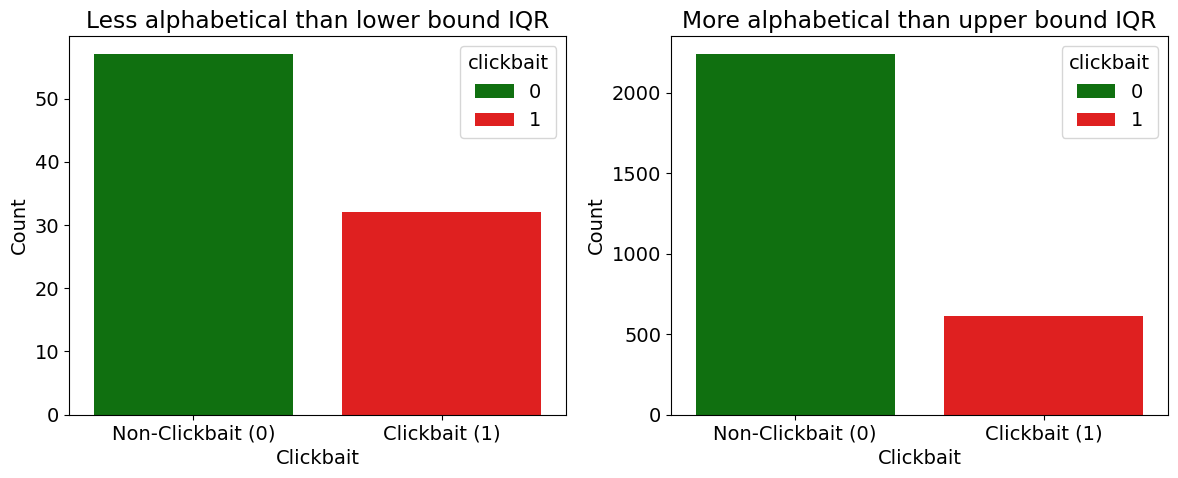

Without outliers:


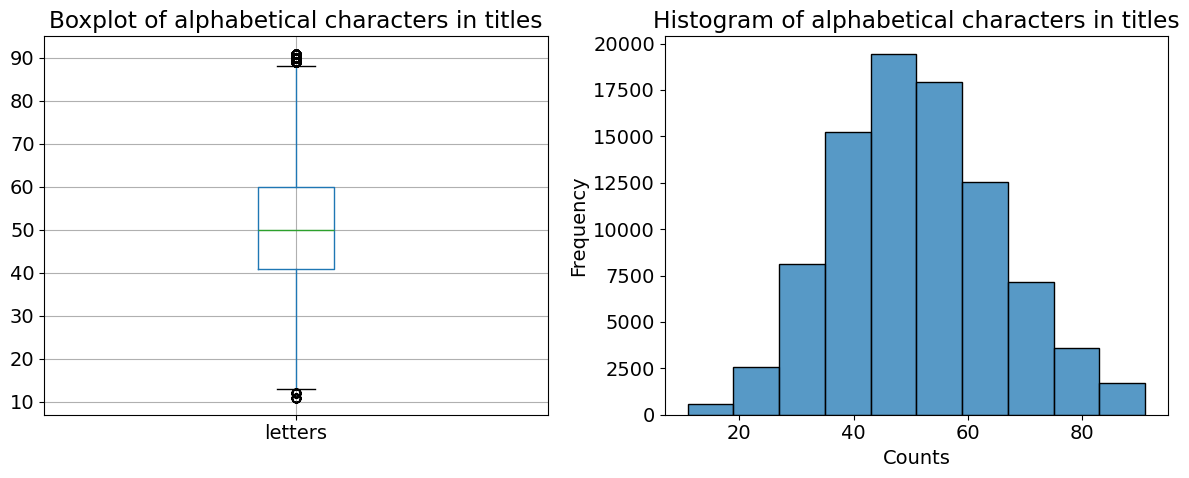

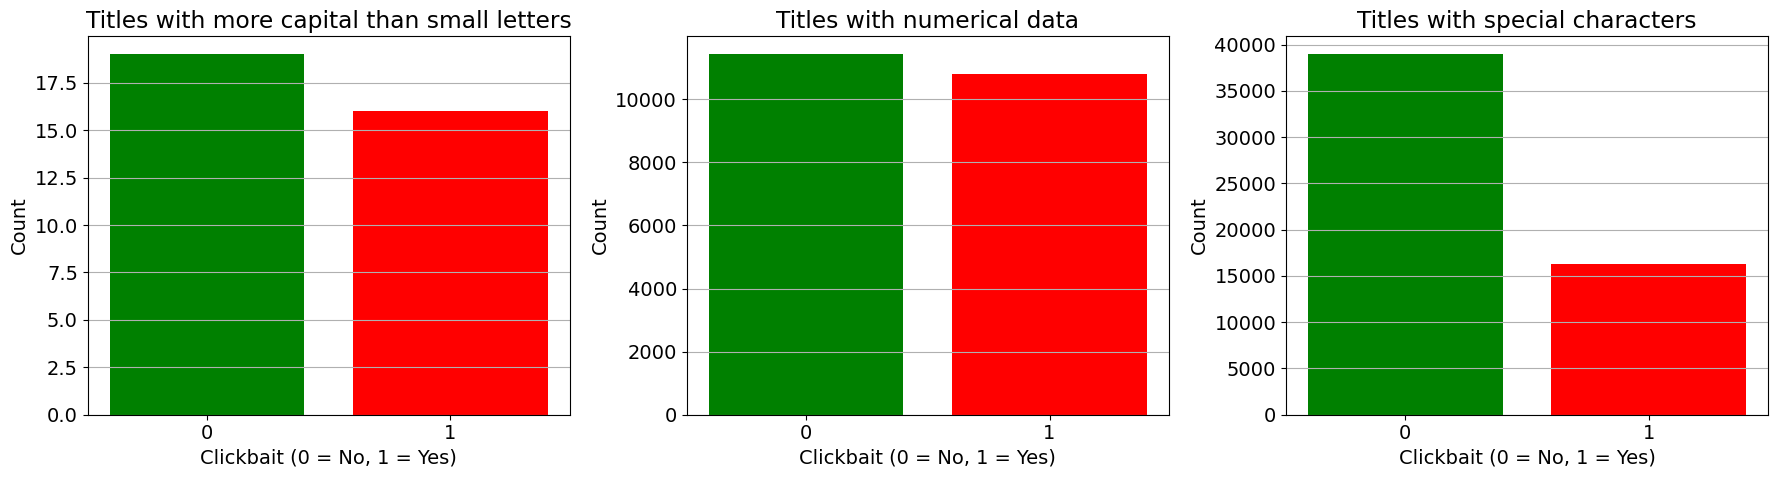

In [129]:
df_merged = analyze_df(df_merged, delete_outliers=DF_MERGED_DELETE_OUTLIERS)

In [130]:
df_merged.to_csv("../data/merged_all_datasets.csv", index=False)

Columns: ['title', 'clickbait', 'set', 'char_capital', 'char_small', 'char_special', 'blank', 'numerical', 'letters', 'outlier']

Shape: (88806, 10)
Number of clickbaits: 29151
Number of no-clickbaits: 59655


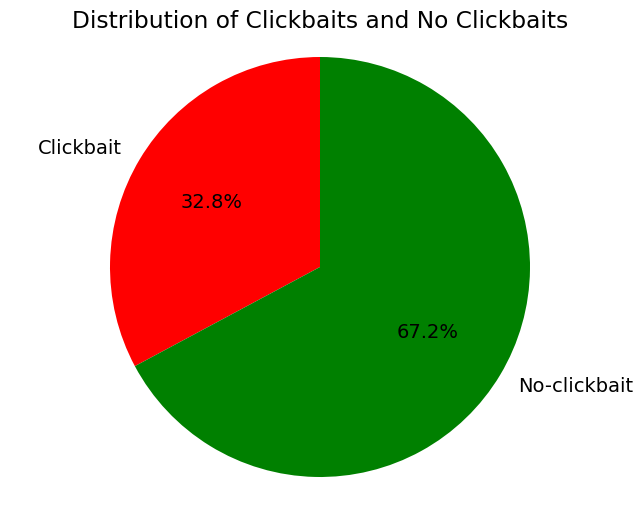


NaN titles dropped: False

Empty titles dropped: 0

Stats:
                 set           char_capital           char_small             \
               mean       std         mean       std       mean        std   
clickbait                                                                    
0          2.198692  0.833188     6.165183  3.998072  45.693923  13.542895   
1          1.764228  0.897156     8.525505  4.000046  39.672944  12.997654   

          char_special               blank           numerical            \
                  mean       std      mean       std      mean       std   
clickbait                                                                  
0             1.387143  1.472675  9.274596  3.047497  0.523912  1.264959   
1             1.132277  1.372281  9.404309  2.960383  0.918836  1.462815   

             letters            outlier       
                mean        std    mean  std  
clickbait                                     
0          51.859107  14.1

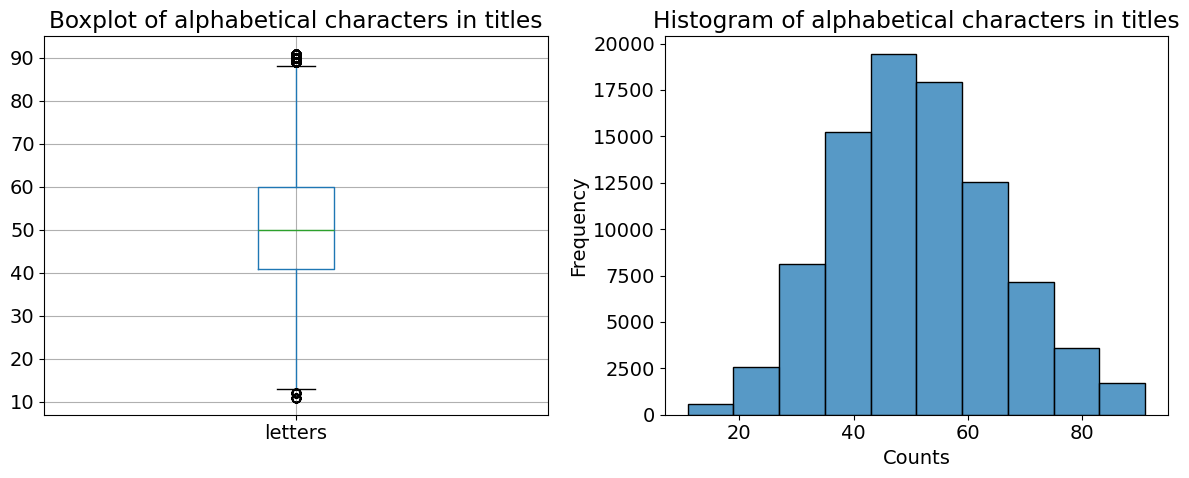

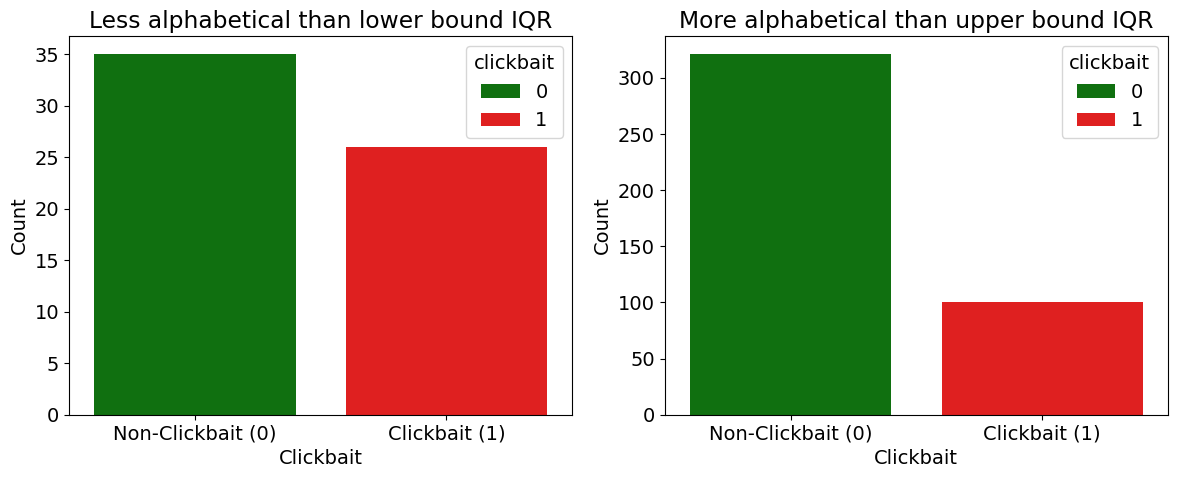

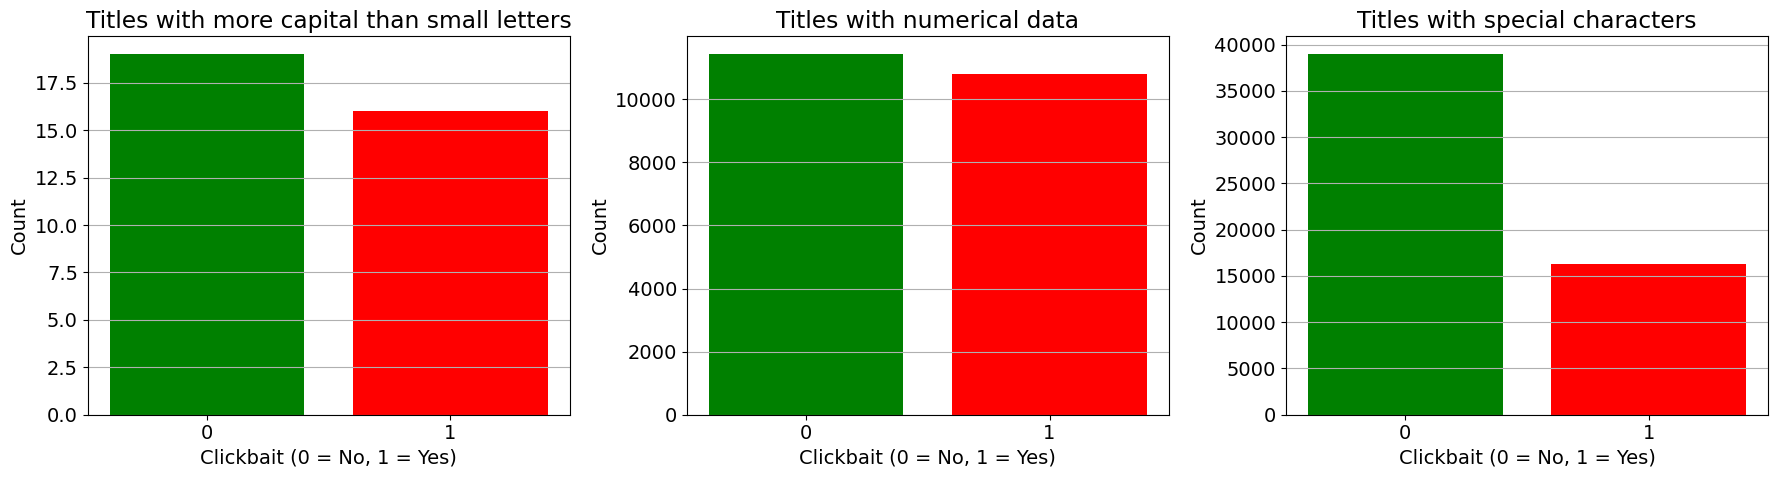

,title,clickbait,set,char_capital,char_small,char_special,blank,numerical,letters,outlier
0,Should I Get Bings,1,1,4,11,0,3,0,15,0
1,Which TV Female Friend Group Do You Belong In,1,1,10,27,0,8,0,37,0
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,1,14,43,3,13,0,57,0
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,1,12,42,2,11,0,54,0
4,A Couple Did A Stunning Photo Shoot With Their...,1,1,18,65,0,17,0,83,0
...,...,...,...,...,...,...,...,...,...,...
40971,"NBC News Video See Brazil Soccer Team, Pilot’s...",0,3,15,53,2,12,0,68,0
40972,Politico Scoop: Eric Trump Killed Two Deer,1,3,7,28,1,6,0,35,0
40973,Frenchs Forest high school may relocate to mak...,0,3,2,83,1,16,0,85,0
40974,Los Angeles Rams Jeff Fisher May Think Danny W...,0,3,12,57,0,13,0,69,0


In [131]:
analyze_df(df_merged)

C:\Users\wojom\AppData\Local\Temp\ipykernel_21684\1343264967.py:39: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.

C:\Users\wojom\AppData\Local\Temp\ipykernel_21684\1343264967.py:39: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



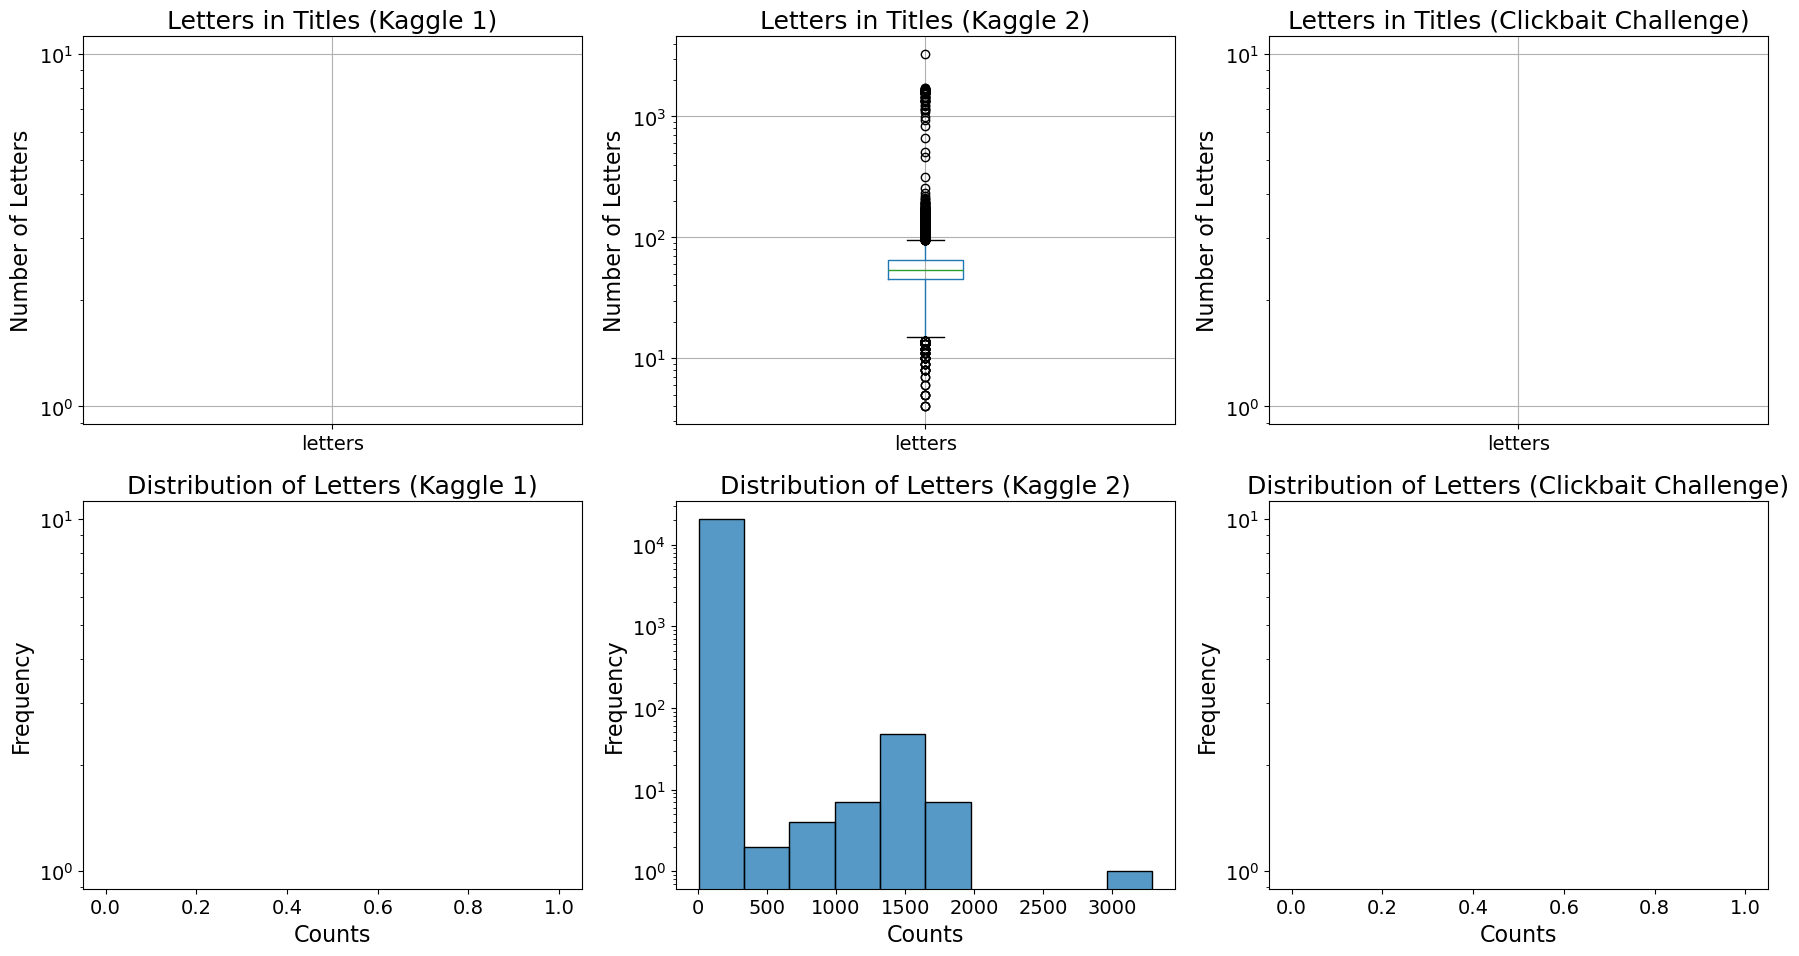

In [133]:
labels = ["Kaggle 1", "Kaggle 2", "Clickbait Challenge"]

def letters_plot_by_set(df, log_scale=False, kde=False):
    # Set font size for the entire figure
    plt.rcParams.update({'font.size': 14})  # Adjust this value for your preference

    # Create subplots: 2 rows, 3 columns
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    for i, dataset in enumerate(df['set'].unique().tolist()):
        dataset_df = df[df['set'] == dataset]
        # Create a boxplot for the 'letters' column, grouped by 'set'
        dataset_df.boxplot(column='letters', ax=axs[0, i])
        
        # Set the title and labels for the boxplot
        axs[0, i].set_title(f'Letters in Titles ({labels[i]})', fontsize=18)  # Increased font size
        # axs[0, i].set_xlabel('Letters', fontsize=16)
        axs[0, i].set_ylabel('Number of Letters', fontsize=16)  # Increased font size

        # Remove the default title from the boxplot created by pandas
        plt.suptitle('')  # Suppress the default title to avoid clutter

        # Apply log scale if specified for the boxplot
        if log_scale:
            axs[0, i].set_yscale('log')

    # Create histograms for the 'letters' column for each dataset
    for i, dataset in enumerate(df['set'].unique()):
        dataset_df = df[df['set'] == dataset]  # Filter data for the specific set
        sns.histplot(dataset_df["letters"], bins=10, kde=kde, ax=axs[1, i], edgecolor="black")
        
        # Set titles and labels for histograms
        axs[1, i].set_title(f'Distribution of Letters ({labels[i]})', fontsize=18)  # Increased font size
        axs[1, i].set_xlabel('Counts', fontsize=16)  # Increased font size
        axs[1, i].set_ylabel('Frequency', fontsize=16)  # Increased font size

        # Apply log scale if specified for the histogram
        if log_scale:
            axs[1, i].set_yscale('log')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# letters_plot_by_set(df_temp, log_scale=True)  # Replace with your actual DataFrame

letters_plot_by_set(df_temp, log_scale=True, kde=False)

In [134]:
df_0_huge = df_merged[df_merged['clickbait'] == 0].sample(n=20000, random_state=42)
df_1_huge = df_merged[df_merged['clickbait'] == 1].sample(n=20000, random_state=42)
df_balanced_huge = pd.concat([df_0_huge, df_1_huge])

df_balanced_huge.to_csv("../data/merged_datasetes_balanced_huge.csv", index=False)

In [137]:
x_train, x_test, y_train, y_test = train_test_split(
    df_balanced_huge["title"], 
    df_balanced_huge["clickbait"],
    test_size=0.2, 
    random_state=42,
    stratify=df_balanced_huge["clickbait"]
)


NaN titles dropped: False

Empty titles dropped: 0


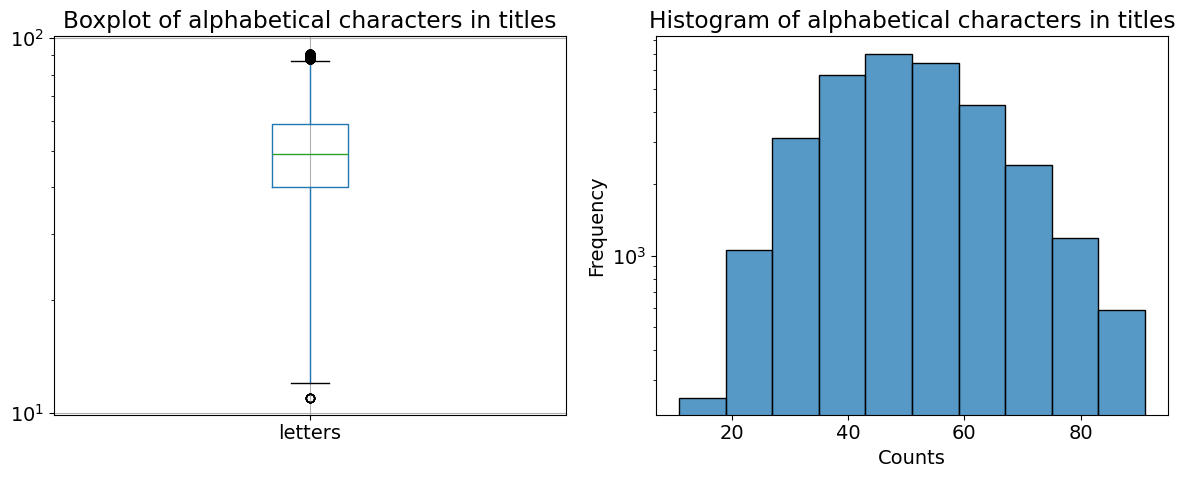

In [ ]:
train_df = pd.concat([x_train, y_train], axis=1)
train_df = text_analysis(train_df)
plot_letters(train_df, log_scale=True)


NaN titles dropped: False

Empty titles dropped: 0


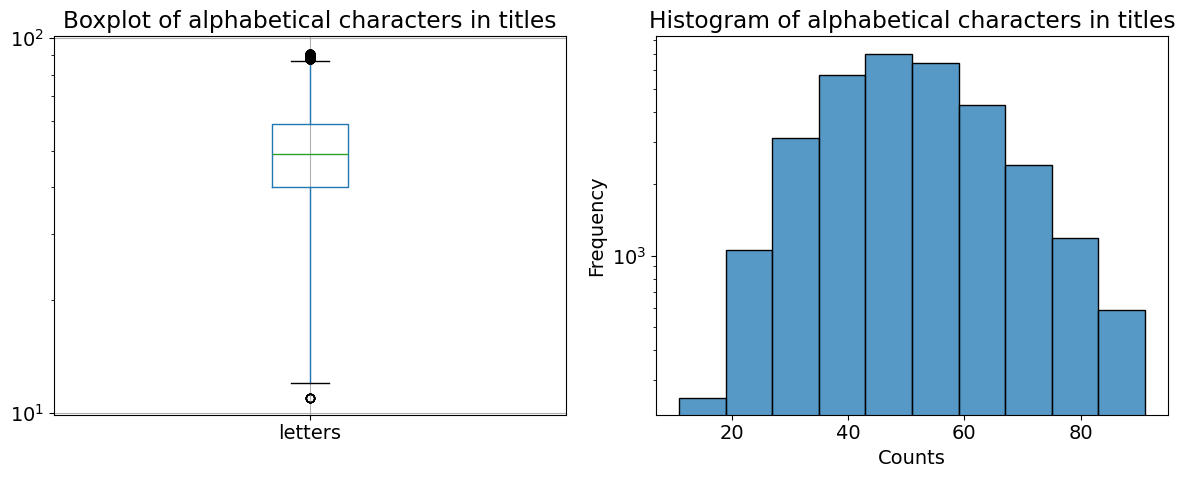

In [142]:
test_df = pd.concat([x_test, y_test], axis=1)
test_df = text_analysis(test_df)
plot_letters(train_df, log_scale=True)

Columns: ['title', 'clickbait', 'set', 'char_capital', 'char_small', 'char_special', 'blank', 'numerical', 'letters', 'outlier']

Shape: (40000, 10)
Number of clickbaits: 20000
Number of no-clickbaits: 20000


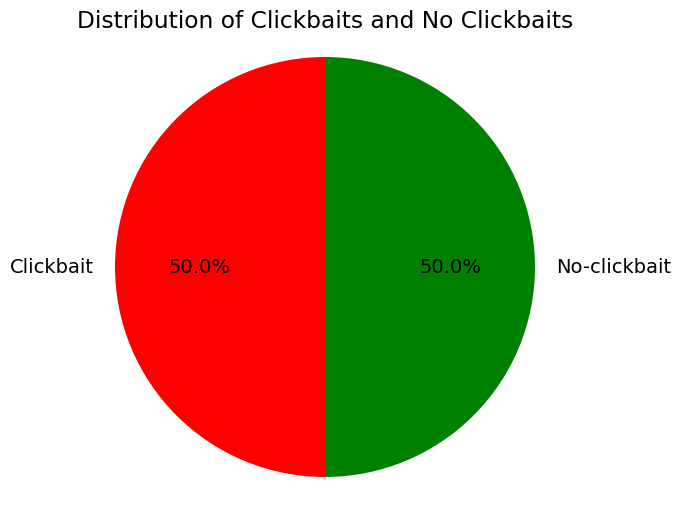


NaN titles dropped: False

Empty titles dropped: 0

Stats:
                set           char_capital           char_small             \
              mean       std         mean       std       mean        std   
clickbait                                                                   
0          2.19735  0.836204       6.1499  3.973326    45.5378  13.619803   
1          1.75930  0.895658       8.5151  3.972866    39.6854  13.059007   

          char_special             blank           numerical            \
                  mean       std    mean       std      mean       std   
clickbait                                                                
0               1.3887  1.461273  9.2363  3.041928   0.52545  1.269422   
1               1.1334  1.373936  9.3963  2.954874   0.92380  1.468026   

           letters            outlier       
              mean        std    mean  std  
clickbait                                   
0          51.6877  14.243925     0.0  0.0  
1 

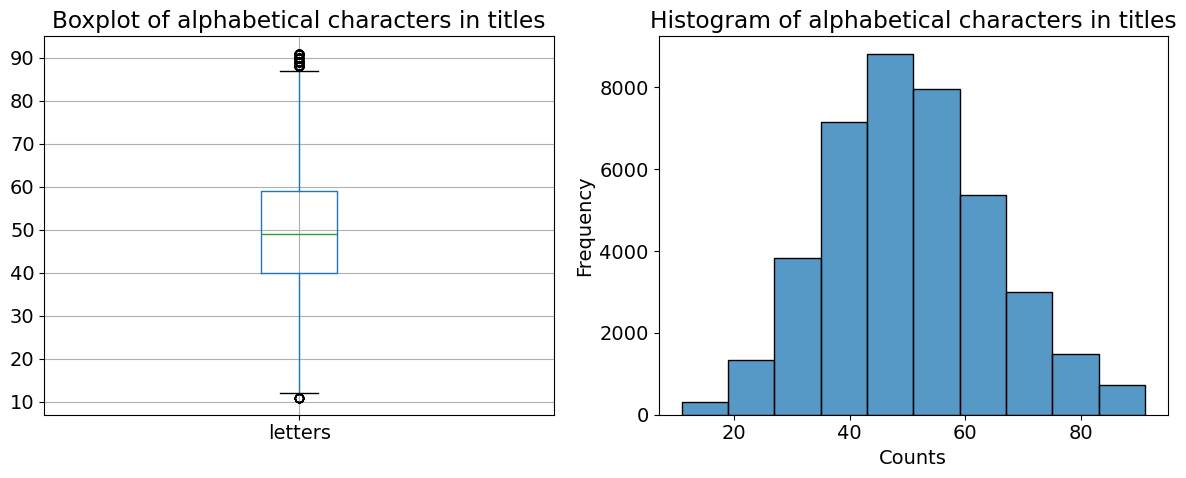

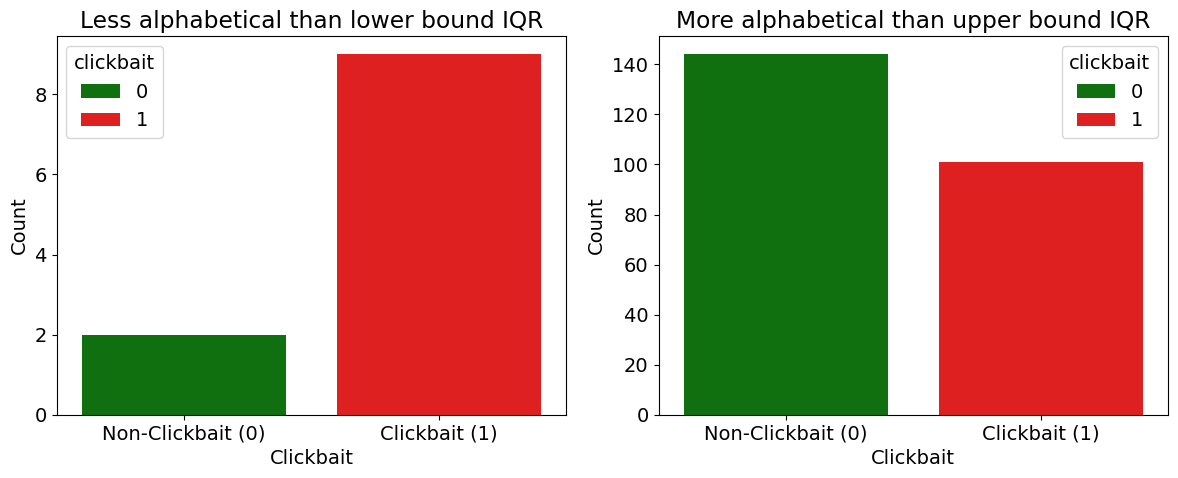

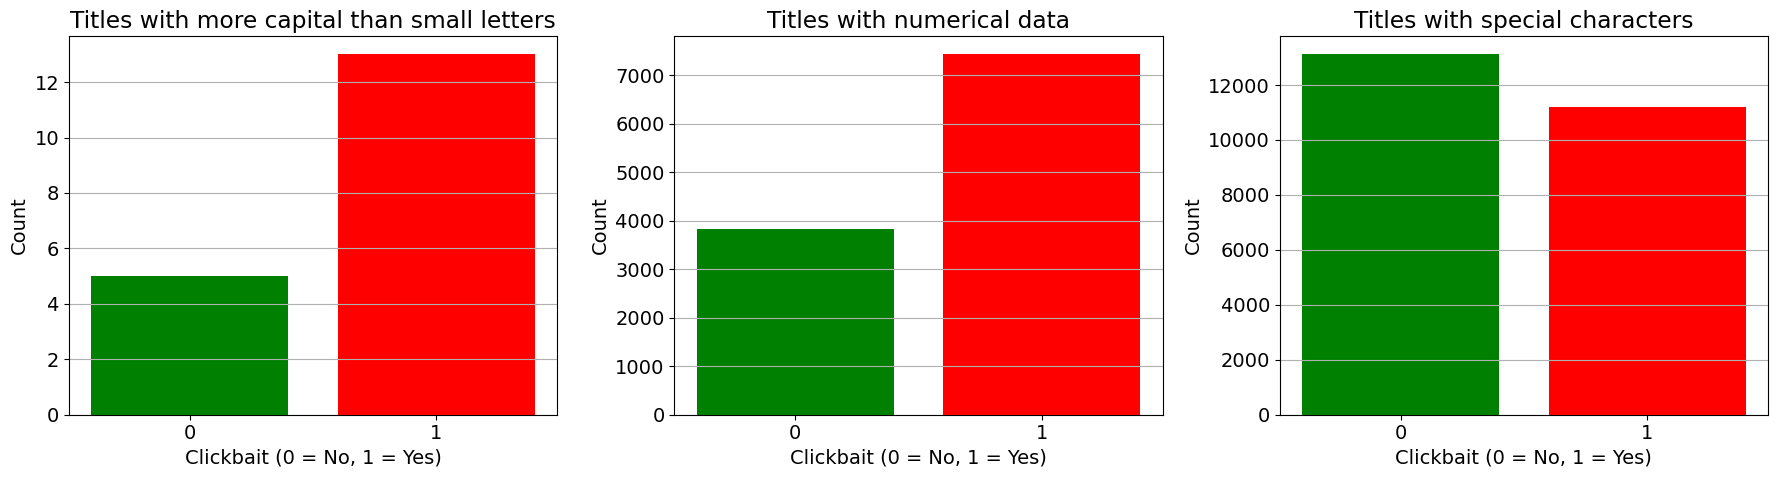

,title,clickbait,set,char_capital,char_small,char_special,blank,numerical,letters,outlier
9558,Weak Federal Powers Could Limit Trump’s Climat...,0,2,9,45,2,8,0,54,0
3296,Son of boxer Muhammad Ali reportedly detained ...,0,3,5,76,0,15,0,81,0
17716,Takk's great escape: The UCLA pass-rusher's re...,0,3,6,45,4,7,0,51,0
7989,Soulja Boy Apologizes for Chris Brown Feud in ...,0,3,13,56,4,14,0,69,0
8330,Football sex abuse: Scotland Yard launches inv...,0,3,4,73,1,12,0,77,0
...,...,...,...,...,...,...,...,...,...,...
2972,"For 105-mph-throwing Michael Kopech, breaking ...",1,3,3,63,3,12,3,66,0
3349,"12 Hacks To Make Netflix, Hulu And Amazon Prim...",1,1,10,41,1,10,2,51,0
11506,How Many Of These Michael Cera Movies Have You...,1,1,10,32,0,9,0,42,0
9367,"Do You Know These Secondary ""Game Of Thrones"" ...",1,1,9,37,2,8,0,46,0


In [ ]:
analyze_df(df_balanced_huge)

In [ ]:
df_0 = df_merged[df_merged['clickbait'] == 0].sample(n=10000, random_state=42)
df_1 = df_merged[df_merged['clickbait'] == 1].sample(n=10000, random_state=42)
df_balanced = pd.concat([df_0, df_1])

df_balanced.to_csv("../data/merged_datasetes_balanced.csv", index=False)

## + Dataset with body: clickbait challange
https://webis.de/events/clickbait-challenge/shared-task.html

In [ ]:
files = ["clickbait17-train-170331", "clickbait17-test-170720", "clickbait17-validation-170630"]
body_dfs = []
for filename in files:
    part_df = load_data_cc(filename, columns=["targetParagraphs"])
    part_df['body'] = part_df['targetParagraphs'].apply(lambda x: " ".join(x))
    part_df = part_df[['title', 'body', 'clickbait']]
    body_dfs.append(part_df)
df_body = pd.concat(body_dfs).reset_index(drop=True)

In [ ]:
df_body['clickbait'].value_counts()

clickbait
0    30938
1    10038
Name: count, dtype: int64

In [ ]:
df_body.to_csv("../data/cc_dataset.csv", index=False)

In [ ]:
df_00 = df_body[df_body['clickbait'] == 0].sample(n=10000, random_state=37)
df_01 = df_body[df_body['clickbait'] == 1].sample(n=10000, random_state=37)

df_body_balanced = pd.concat([df_00, df_01])

In [ ]:
df_body_balanced.to_csv("../data/cc_dataset_balanced.csv", index=False)

## Clickbait spoiling dataset

https://pan.webis.de/semeval23/pan23-web/clickbait-challenge.html

In [ ]:
"""
Vocab:
task 1: spoiler type classification
task 2: spoiler generation / extraction

Columns:
targetTitle: The title of the linked web page.
targetParagraphs: The main content of the linked web page. Consists of the paragraphs of manually extracted main content.
humanSpoiler: The human generated spoiler (abstractive) for the clickbait post from the linked web page. Beware, there is a lot of missing values.
spoiler: The human extracted spoiler for the clickbait post from the linked web page.
spoilerPositions: The position of the human extracted spoiler for the clickbait post from the linked web page.
tags: The spoiler type (might be "phrase", "passage", or "multi") that is to be classified in task 1 (spoiler type classification).

How to use spoilerPositions:
if `data['spoilerPositions'][0]` is `[[[3, 151], [3, 186]]]`,
then `data['targetParagraphs'][0][3][151:186]` equals `data['spoiler']`
"""

'\nVocab:\ntask 1: spoiler type classification\ntask 2: spoiler generation / extraction\n\nColumns:\ntargetTitle: The title of the linked web page.\ntargetParagraphs: The main content of the linked web page. Consists of the paragraphs of manually extracted main content.\nhumanSpoiler: The human generated spoiler (abstractive) for the clickbait post from the linked web page. Beware, there is a lot of missing values.\nspoiler: The human extracted spoiler for the clickbait post from the linked web page.\nspoilerPositions: The position of the human extracted spoiler for the clickbait post from the linked web page.\ntags: The spoiler type (might be "phrase", "passage", or "multi") that is to be classified in task 1 (spoiler type classification).\n\nHow to use spoilerPositions:\nif `data[\'spoilerPositions\'][0]` is `[[[3, 151], [3, 186]]]`,\nthen `data[\'targetParagraphs\'][0][3][151:186]` equals `data[\'spoiler\']`\n'

In [ ]:
names = ['train', 'validation']
spoil_dfs = []
for name in names:
    data_file_path = f'../../data/spoiling-clickbait-22/{name}.jsonl'
    with open(data_file_path, 'rb') as file:
        part_df = pd.read_json(file,lines=True)

    part_df['humanSpoiler'] = part_df['provenance'].apply(lambda x: x['humanSpoiler'])
    part_df = part_df[["targetTitle", "targetParagraphs", "humanSpoiler", "spoiler", "spoilerPositions", "tags"]]
    spoil_dfs.append(part_df)
spoil_df = pd.concat(spoil_dfs).reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/spoiling-clickbait-22/train.jsonl'

In [ ]:
spoil_df.to_csv("../data/spoiling_data.csv", index=False)

NameError: name 'spoil_df' is not defined

In [ ]:
def remove_brackets(text):
  """
  Removes brackets
  """
  if isinstance(text, float):
    return text
  res=""
  brackets = ["[","]","'","\""]
  num_letters = len(text)
  for i in range(num_letters):     
    if text[i] in brackets:
      continue
    res += text[i]
  return res

In [ ]:
spoil_df = pd.read_csv("../data/spoiling_data.csv")

In [ ]:
spoil_df.head()

targetTitle  \
0                                       Wes Welker Wanted Dinner With Tom Brady, But Patriots QB Had A Better Idea   
1                                                 Hole In Ozone Layer Expected To Make Full Recovery By 2070: NASA   
2                                       Intellectual Stimulation Trumps Money For Employee Happiness, Survey Finds   
3                                               ‘Follow your passion’ is wrong, here are 7 habits you need instead   
4  Revealed: The perfect way to cook rice so that it's perfectly fluffy and NEVER sticks to the bottom of the pan    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
print(f"Shape before removing null: {spoil_df.shape}")
nan_counts = (spoil_df.isnull() | (spoil_df == '')).sum()
print(nan_counts)
spoil_df = spoil_df.dropna()
print(f"Shape after removing null: {spoil_df.shape}")

Shape before removing null: (4000, 6)
targetTitle           2
targetParagraphs      0
humanSpoiler        640
spoiler               0
spoilerPositions      0
tags                  0
dtype: int64
Shape after removing null: (3358, 6)


In [ ]:
position_col = spoil_df["spoilerPositions"]
spoil_df = spoil_df.drop(columns=["spoilerPositions"]).applymap(remove_brackets)
spoil_df["spoilerPositions"] = position_col
spoil_df.head()

C:\Users\wojom\AppData\Local\Temp\ipykernel_17292\999323048.py:2: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,targetTitle,targetParagraphs,humanSpoiler,spoiler,tags,spoilerPositions
0,"Wes Welker Wanted Dinner With Tom Brady, But Patriots QB Had A Better Idea","It’ll be just like old times this weekend for Tom Brady and Wes Welker., Welker revealed Friday morning on a Miami radio station that he contacted Brady because he’ll be in town for Sunday’s game between the New England Patriots and Miami Dolphins at Gillette Stadium. It seemed like a perfect opportunity for the two to catch up., But Brady’s definition of catching up involves far more than just a meal. In fact, it involves some literal catching as the Patriots quarterback looks to stay sharp during his four-game Deflategate suspension., I hit him up to do dinner Saturday night. He’s like, ‘I’m going to be flying in from Ann Arbor later (after the Michigan-Colorado football game), but how about that morning we go throw?’ Welker said on WQAM, per The Boston Globe. And I’m just sitting there, I’m like, ‘I was just thinking about dinner, but yeah, sure. I’ll get over there early and we can throw a little bit.’ , Welker was one of Brady’s favorite targets for six seasons from 2007 to 2012. It’s understandable him and Brady want to meet with both being in the same area. But Brady typically is all business during football season. Welker probably should have known what he was getting into when reaching out to his buddy., That’s the only thing we really have planned, Welker said of his upcoming workout with Brady. It’s just funny. I’m sitting there trying to have dinner. ‘Hey, get your ass up here and let’s go throw.’ I’m like, ‘Aw jeez, man.’ He’s going to have me running like 2-minute drills in his backyard or something., Maybe Brady will put a good word in for Welker down in Foxboro if the former Patriots wide receiver impresses him enough.",They Threw A Football,how about that morning we go throw?,passage,"[[[3, 151], [3, 186]]]"
1,Hole In Ozone Layer Expected To Make Full Recovery By 2070: NASA,"2070 is shaping up to be a great year for Mother Earth., Thats when NASA scientists are predicting the hole in the ozone layer might finally make a full recovery. Researchers announced their conclusion, in addition to other findings, in a presentation Wednesday during the annual American Geophysical Union meeting in San Francisco., The team of scientists specifically looked at the chemical composition of the ozone hole, which has shifted in both size and depth since the passing of the Montreal Protocol in 1987. The agreement banned its 197 signatory countries from using chemicals, like chlorofluorocarbons (CFCs), that break down into chlorine in the upper atmosphere and harm the ozone layer., They found that, while levels of chlorine in the atmosphere have indeed decreased as a result of the protocol, its too soon to tie them to a healthier ozone layer., Ozone holes with smaller areas and a larger total amount of ozone are not necessarily evidence of recovery attributable to the expected chlorine decline, Susan Strahan of NASA\s Goddard Space Flight Center explained in a media briefing. That assumption is like trying to understand what\s wrong with your car\s engine without lifting the hood., Instead, the scientists believe the most recent ozone hole changes, including both the largest hole ever, in 2006, and one of the smallest holes, in 2012, are primarily due to weather. Strong winds have the ability to move ozone in large quantities, effectively blocking the hole some years, while failing to block it in others., At the moment, it is winds and temperatures that are really controlling how big the ozone hole is, Strahan told the BBC., LiveScience reports weather is expected to be the predominant factor in the ozone holes size until 2025, at which point CFCs will have dropped enough as a result of the Montreal Protocol to become noticeable., By 2070, however, the ozone hole is expected to have made a full recovery., It’s not going to be a smooth ride, Strahan cautioned the Los Angeles Time

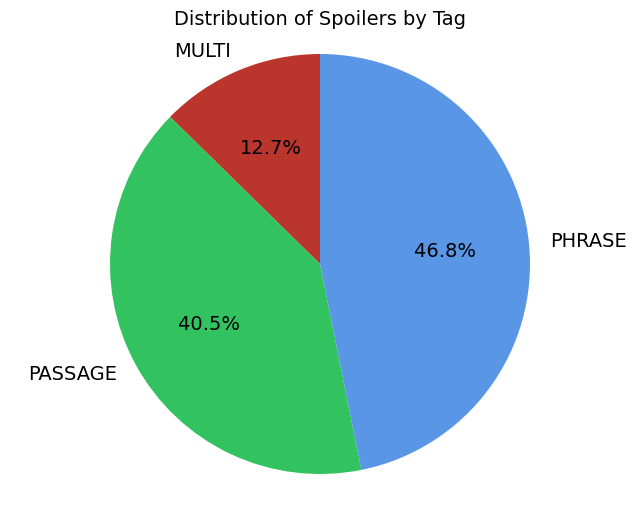

In [ ]:
counted_tags = pd.DataFrame(spoil_df.groupby(["tags"]).count()["targetTitle"].reset_index())

labels = [tag.upper() for tag in counted_tags["tags"]]
sizes = counted_tags["targetTitle"]
colors = ["#ba362d", '#32c260', '#5a96e6']
explode = (0, 0, 0)

plt.figure(figsize=(8, 6))
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    shadow=False,
    startangle=90,
    textprops={'fontsize': 14}
)
plt.axis('equal')
plt.title('Distribution of Spoilers by Tag', fontsize=14)
plt.show()


NaN titles dropped: False

Empty titles dropped: 0


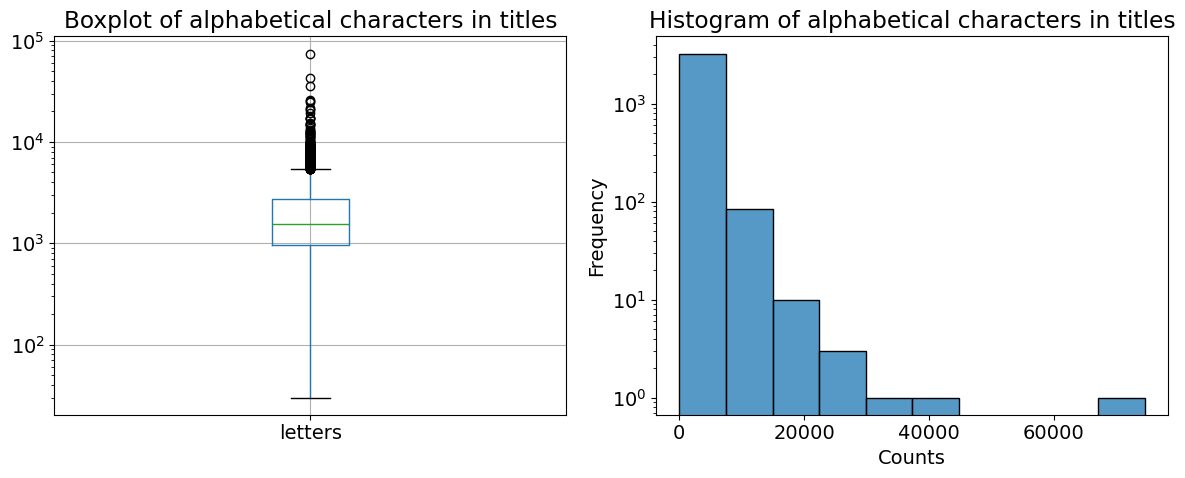

In [ ]:
df_targetParagraphs = text_analysis(spoil_df, colname="targetParagraphs")
plot_letters(df_targetParagraphs, log_scale=True)

In [ ]:
pd.set_option('display.max_colwidth', None)  # Set to None to display all text

tags = ["passage", "phrase", "multi"]
for tag in tags:
    df = spoil_df.loc[spoil_df["tags"] == tag, ["targetTitle", "humanSpoiler", "spoiler"]].iloc[0:1]
    print(tag)
    print(f"Target title: {df['targetTitle'].to_string(index=False)}")
    print(f"Human spoiler: {df['humanSpoiler'].to_string(index=False)}")
    print(f"Spoiler: {df['spoiler'].to_string(index=False)}")
    print()
pd.set_option('display.max_colwidth', 50)

passage
Target title: Wes Welker Wanted Dinner With Tom Brady, But Patriots QB Had A Better Idea
Human spoiler: They Threw A Football
Spoiler: how about that morning we go throw?

phrase
Target title: Hole In Ozone Layer Expected To Make Full Recovery By 2070: NASA
Human spoiler: 2070
Spoiler: 2070

multi
Target title: Taste test: 29 hot sauce bottles, ranked
Human spoiler: Its Sriracha, its always sriracha
Spoiler: Sriracha Hot Chili Sauce, Franks RedHot Original Sauce, Cholula Chili Garlic, Louisiana Hot Sauce, CaJohns Bourbon Infused Chipotle-Habañero Sauce




NaN titles dropped: False

Empty titles dropped: 0


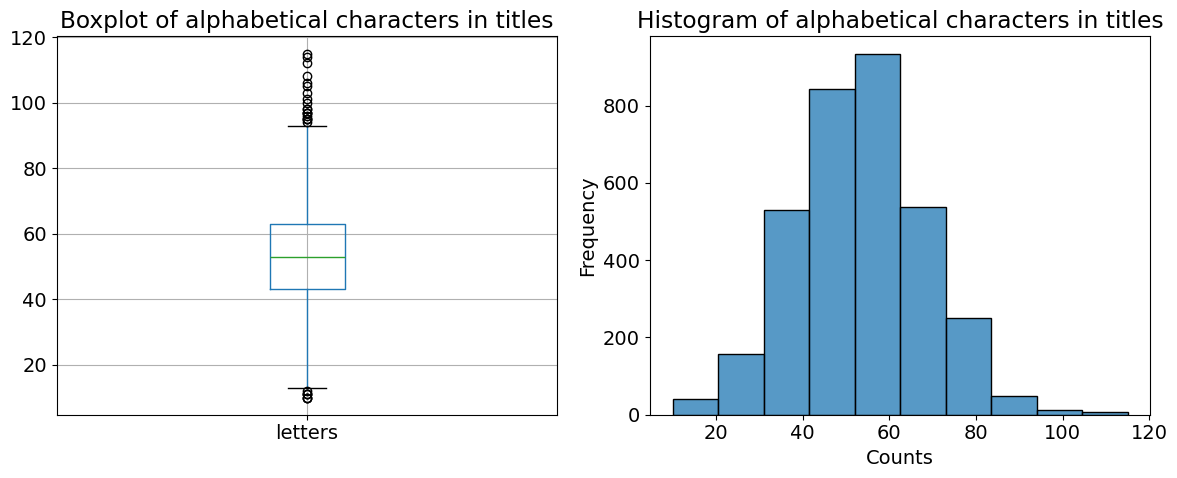

In [ ]:
df_targetTitle = text_analysis(spoil_df, colname="targetTitle")
plot_letters(df_targetTitle)

In [ ]:
df_humanSpoiler = text_analysis(spoil_df, colname="humanSpoiler")
stats = df_humanSpoiler.drop(columns=["targetTitle",	"targetParagraphs",	"humanSpoiler",	"spoiler", "spoilerPositions"]).groupby('tags').agg(['mean', 'std']).round(1)
print("\nStats:\n", stats)


NaN titles dropped: False

Empty titles dropped: 25

Stats:
         char_capital      char_small       char_special      blank        \
                mean  std       mean   std         mean  std  mean   std   
tags                                                                       
multi            4.0  5.0       53.5  50.6          2.9  3.6  10.7  12.1   
passage          2.9  3.1       47.4  38.5          1.8  2.0   9.6   8.4   
phrase           2.8  2.4       26.4  30.2          1.4  1.8   4.9   6.9   

        numerical      letters        
             mean  std    mean   std  
tags                                  
multi         0.7  2.0    57.5  53.0  
passage       0.4  1.5    50.2  39.5  
phrase        0.5  1.9    29.2  31.1  


In [ ]:
spoil_df.to_csv("../data/spoiling_data.csv", index=False)